<a href="https://colab.research.google.com/github/Sangyeup/BHI_Study/blob/main/NN_%EC%97%AC%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build 3 Layer Network

- input layer
- 2 hidden layer
- output layer
<br>
<br>
- Loss function : Cross Entropy Error

In [1]:
import numpy as np

In [2]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 826, done.
remote: Total 826 (delta 0), reused 0 (delta 0), pack-reused 826
Receiving objects: 100% (826/826), 52.21 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [3]:
import os
os.chdir('/content/deep-learning-from-scratch')
!pwd

/content/deep-learning-from-scratch


## Define Functions

In [4]:
# sigmoid

def sigmoid(x):   
    return 1/(1+np.exp(-x))

In [17]:
# cross_entropy_error
# y : predicted value
# t : label

def cross_entropy_error(y, t):
  # print(y.shape)
  # print(t.shape)
  if y.ndim==1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  delta = 1e-7
  batch_size = y.shape[0]
  loss = -np.sum(t*np.log(y+delta))/batch_size
  return loss


In [6]:
# softmax
# x : input
# Overflow 방지 -> input 중 가장 큰 값 전체 데이터에서 빼주기

def softmax(x):
    c = x.max(axis=1, keepdims=True)
    exp_a = np.exp(x-c)
    sum_exp_a = exp_a.sum(axis=1, keepdims=True)
    y = exp_a/sum_exp_a
    return y
    

In [18]:
# numerical_gradient
# 수치 미분법
# f : function
# x : variable
# 각 변수에 대한 편미분 저장된 배열 return

def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)
  iter = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
  with iter:
    while not iter.finished:
      idx = iter.multi_index
      temp_val = x[idx]
      x[idx] = temp_val+h
      fxh1 = f(x)
      x[idx] = temp_val-h
      fxh2 = f(x)
      grad[idx] = (fxh1-fxh2)/(2*h)
      x[idx] = temp_val
      iter.iternext()

  return grad

## Define Network by Class

In [22]:
class ThreeLayerNet:
    # 초기화
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, weight_init_std=0.01):
        
        # initialize parameters
        # W -> random 
        # b -> 0
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1'] = np.zeros(hidden_size_1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2'] = np.zeros(hidden_size_2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size_2, output_size)
        self.params['b3'] = np.zeros(output_size)

        
        
    # 예측 함수
    # x : 입력 데이터
    # y : 예측값
    def predict(self,x):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        a1 = np.dot(x, W1)+b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2)+b2
        z2 = sigmoid(a2)
        a3 = np.dot(z2, W3)+b3
        y = softmax(a3)
        return y
    
    
    # 손실 함수
    # cross_entropy_error 사용
    # x : 입력 데이터
    # t : 정답 레이블
    def loss(self, x, t):
        
        y=self.predict(x)
        return cross_entropy_error(y,t)
    
    
    # 정확도 함수
    # x : 입력 데이터
    # t : 정답 레이블
    # x 중 예측값 == 정답 레이블 비율
    # accuracy = (정답 맞춘 데이터 수) / (전체 데이터 수)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    
    # 기울기 함수
    # 수치 미분법으로 계산
    # x : 입력 데이터
    # t : 정답 레이블
    def gradient(self, x, t):
        # get loss function
        loss_W = lambda W: self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        return grads

## train, test - MNIST

교재 github에서 /dataset/mnist.py 다운로드 후 load_mnist import해서 사용

**ThreeLayerNet으로 train, test**

- input_size = 784
- hidden_size_1 = 50
- hidden_size_2 = 100
- output_size = 10
- batch_size = 100
- learning_rate = 0.1
- iters_num = 5000
- train_size = x_train data 전체

**train loss 그래프 그리기**

In [24]:
import sys, os
sys.path.append(os.pardir)

from dataset.mnist import load_mnist

# load dataset
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []
train_acc_list = []
test_acc_list = []

# Hyperparameters
#### 채워 넣으세요 ####
iters_num = 5000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = ThreeLayerNet(input_size=784, hidden_size_1=50, hidden_size_2=100, output_size=10)

# 1 epoch 되는 iteration
iter_per_epoch = max(train_size/batch_size, 1)

# Train
for i in range(iters_num):
    # get minibatch
    x_batch = x_train[i%train_size:i%train_size+batch_size]
    t_batch = t_train[i%train_size:i%train_size+batch_size]
    grad = network.gradient(x_batch, t_batch)
    for key in grad.keys():
      network.params[key] -= learning_rate*grad[key]
    # gradient 계산 후 parameter update 필요
    
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    # 1 epoch 당 accuracy 계산
    if i%iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        
        print("Train Accuracy: " + str(train_acc) + " & " + "Test Accuracy: " + str(test_acc))

Train Accuracy: 0.11236666666666667 & Test Accuracy: 0.1135


KeyboardInterrupt: ignored

### Visualize Loss
- loss 보여주는 plot

- 맘대로 시각화하면 됩니다

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

NameError: ignored

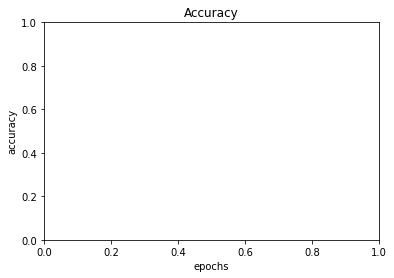

In [43]:
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(x, train_acc_list, label = 'train acc')
plt.plot(x, test_acc_list, label = 'test acc', linestyle = '--')
plt.legend(loc = 'best')
plt.show()